In [43]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut, cross_validate, GroupKFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# !pip install spatial-kfold
from spatialkfold.blocks import spatial_blocks 
from spatialkfold.clusters import spatial_kfold_clusters 

from shapely import Point, wkt
import osmnx as ox

import warnings
warnings.filterwarnings('ignore')

random_seed = 100

london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
boros = gpd.read_file(os.path.join('data','shapefile','statistical-gis-boundaries-london','ESRI','London_Borough_Excluding_MHW.shp'))
boros.to_crs(epsg=27700, inplace=True)

# 1. Load

In [44]:
df = pd.read_csv('data/cleaned/df_ml_new.csv',low_memory=True)
# df['geometry'] = df['geometry'].apply(wkt.loads)
# df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:27700')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_code                    16890 non-null  object 
 1   geometry                   16890 non-null  object 
 2   population                 16890 non-null  float64
 3   poi_banking                16890 non-null  float64
 4   poi_hotels                 16890 non-null  float64
 5   poi_leisure_active         16890 non-null  float64
 6   poi_leisure_entertainment  16890 non-null  float64
 7   poi_leisure_outdoor        16890 non-null  float64
 8   poi_medical                16890 non-null  float64
 9   poi_nature                 16890 non-null  float64
 10  poi_public_facilities      16890 non-null  float64
 11  poi_religious              16890 non-null  float64
 12  poi_restaurants            16890 non-null  float64
 13  poi_shopping               16890 non-null  flo

In [45]:
# create new columns with log values of target variables
timebands = ['Total', 'Morning', 'Midday', 'Evening', 'Late']
for col in timebands:
    df['log_'+col] = df[col].apply(lambda x: 0 if x==0 else np.log(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_code                    16890 non-null  object 
 1   geometry                   16890 non-null  object 
 2   population                 16890 non-null  float64
 3   poi_banking                16890 non-null  float64
 4   poi_hotels                 16890 non-null  float64
 5   poi_leisure_active         16890 non-null  float64
 6   poi_leisure_entertainment  16890 non-null  float64
 7   poi_leisure_outdoor        16890 non-null  float64
 8   poi_medical                16890 non-null  float64
 9   poi_nature                 16890 non-null  float64
 10  poi_public_facilities      16890 non-null  float64
 11  poi_religious              16890 non-null  float64
 12  poi_restaurants            16890 non-null  float64
 13  poi_shopping               16890 non-null  flo

Define target variable list

In [46]:
# define target variable columns
timebands = ['Total', 'Morning', 'Midday', 'Evening', 'Late']
targets = timebands
targets_log = ['log_'+t for t in targets]

Define features list

In [47]:
# define feature columns
features = ['population', 
            'poi_banking', 'poi_hotels','poi_leisure_active', 'poi_leisure_entertainment','poi_leisure_outdoor',
            'poi_medical', 'poi_nature', 'poi_public_facilities', 'poi_religious','poi_restaurants','poi_tourism','poi_shopping',
            'transport_bus','transport_rail','transport_other',
            'diversity_poi','diversity_transp_mode','diversity_transp_opt',
            'cent_bus_degree','cent_bus_closeness','cent_bus_betweenness',
            'cent_rail_degree','cent_rail_closeness','cent_rail_betweenness'
            ]

# lags as features
lags = ['lag_'+t for t in targets] #to pick one depending on the target

Correlation

Correlation matrix for log_Total


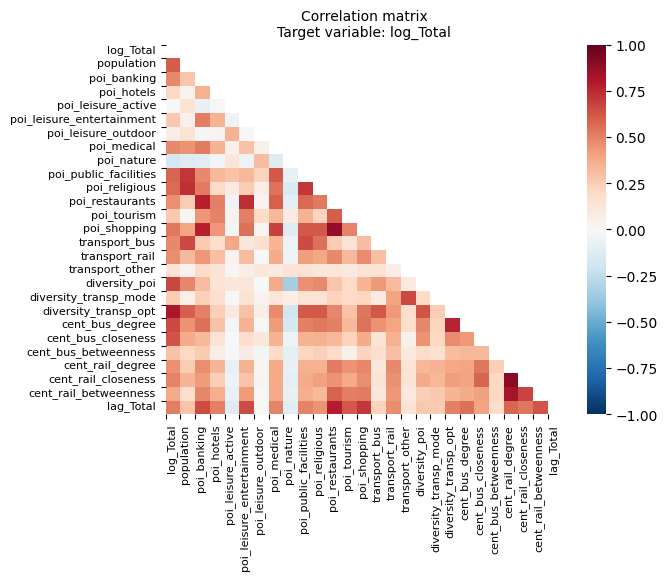

Correlation matrix for log_Morning


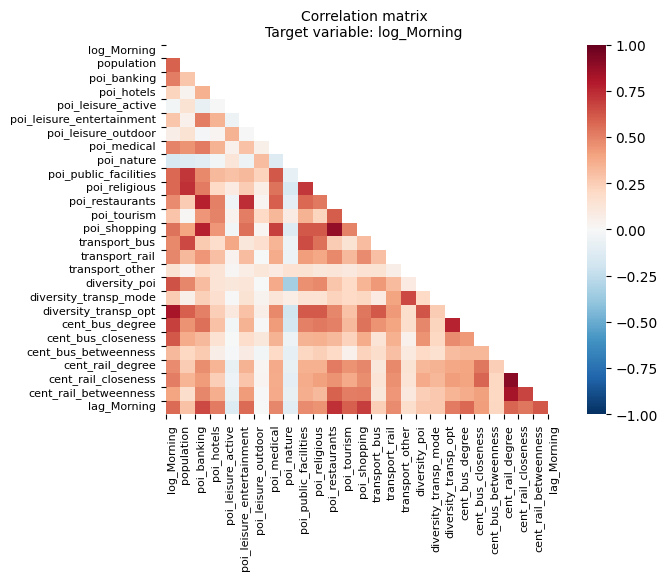

Correlation matrix for log_Midday


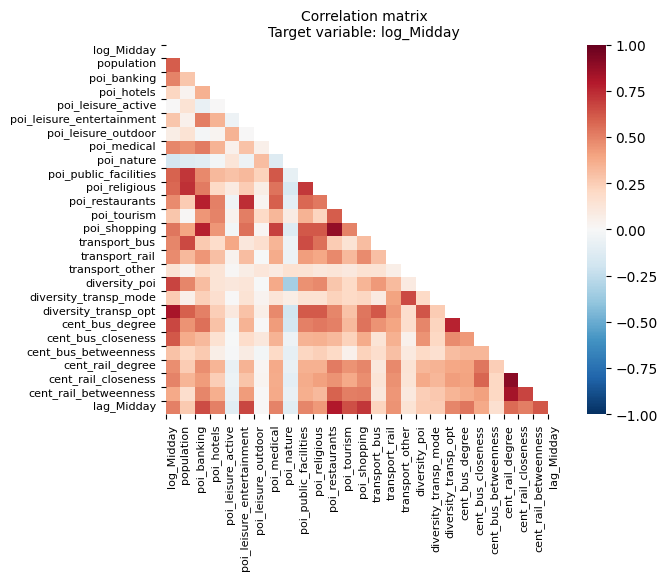

Correlation matrix for log_Evening


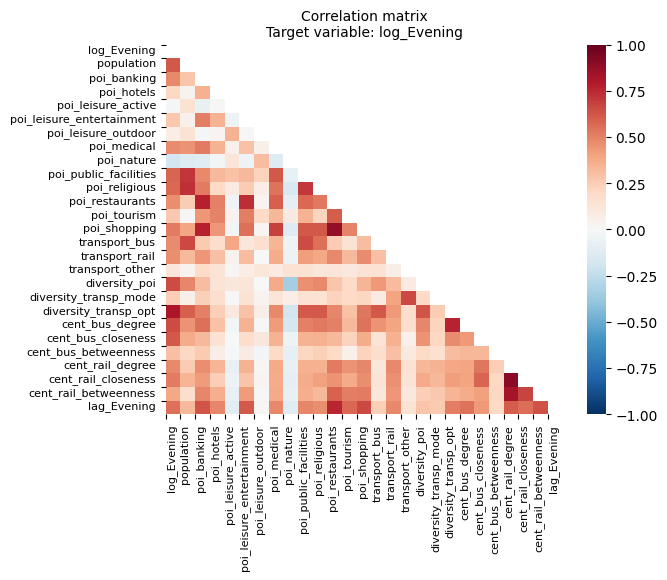

Correlation matrix for log_Late


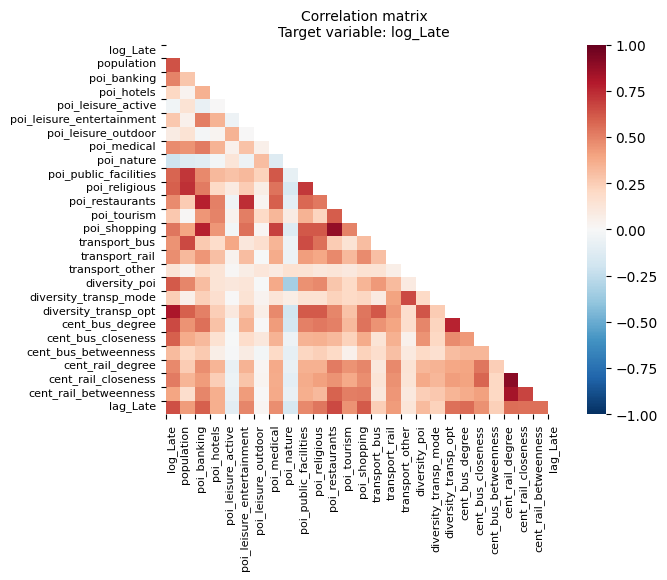

In [27]:
# for each of the target variable, create a correlation matrix graph
import seaborn as sns
for i,tar in enumerate(targets_log): 
    print(f'Correlation matrix for {tar}')
    corr = df[[tar] + features + [lags[i]]].corr()
    mask=np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, cmap='RdBu_r', annot=False, vmin=-1, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical', fontsize=8, ha='left')
    plt.yticks(range(len(corr.columns)), corr.columns, va='top', fontsize=8)
    plt.title(f'Correlation matrix\nTarget variable: {tar}', fontsize=10)

    plt.savefig(os.path.join('output','corr',f'corr_{tar}_log.jpg'))
    plt.show()

# 2. Model selection - Linear, XGBoost, ANN

## Define Spatial Cross-Validation

In [48]:
# 2. Define Spatial Cross-Validation
df_point = df.copy()
df_point['geometry'] = [Point(x,y) for x,y in zip(df_point['x_coords'],df_point['y_coords'])]
df_point = gpd.GeoDataFrame(df_point, geometry='geometry', crs='EPSG:27700')

# spatial kfold
df_clusters = spatial_kfold_clusters (gdf=df_point, name = 'id_code', nfolds = 10, algorithm='kmeans',
                                        random_state = random_seed, verbose = True) 
groups = df_clusters["folds"] # Assuming you have a column defining spatial groups 

# Cross-validation setup
group_cvs =  LeaveOneGroupOut() # for spatial cross-validation when training the data

Initialization complete
Iteration 0, inertia 669708276656.3846.
Iteration 1, inertia 556622288374.3107.
Iteration 2, inertia 523634155347.5055.
Iteration 3, inertia 504628523754.29626.
Iteration 4, inertia 491014146351.51654.
Iteration 5, inertia 481774877637.3203.
Iteration 6, inertia 475936768588.4951.
Iteration 7, inertia 471899867467.47003.
Iteration 8, inertia 468900975774.3592.
Iteration 9, inertia 466888894741.24695.
Iteration 10, inertia 465609131140.9203.
Iteration 11, inertia 464745390646.47.
Iteration 12, inertia 464174424535.8224.
Iteration 13, inertia 463739375344.344.
Iteration 14, inertia 463443414492.0056.
Iteration 15, inertia 463199703139.03784.
Iteration 16, inertia 462933929377.4531.
Iteration 17, inertia 462619284258.08936.
Iteration 18, inertia 462335764970.33234.
Iteration 19, inertia 462091282695.29236.
Iteration 20, inertia 461794874163.27026.
Iteration 21, inertia 461413001506.6301.
Iteration 22, inertia 460825402534.11743.
Iteration 23, inertia 460354008628.4

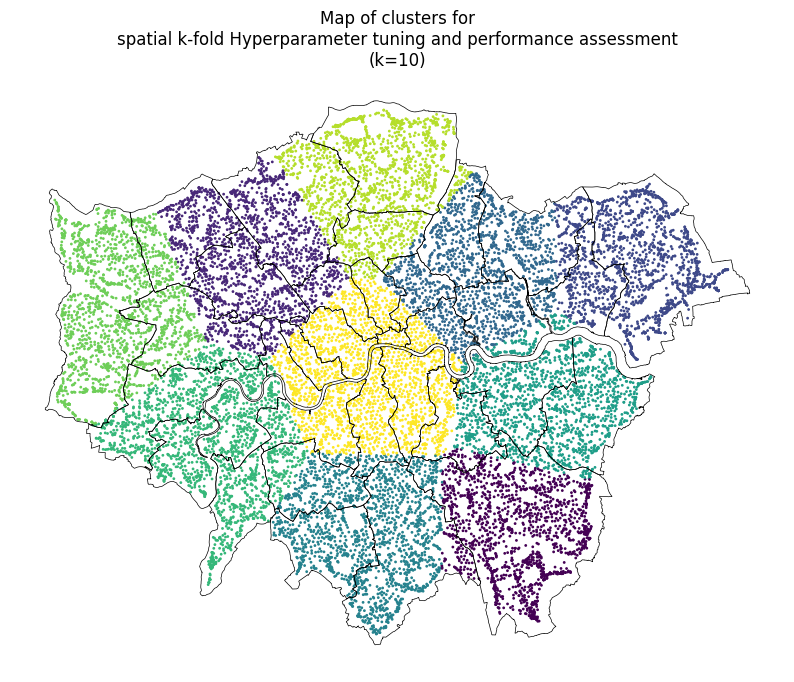

In [42]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
df_clusters.plot(column='folds',ax=ax,legend=False,markersize=1)
boros.boundary.plot(ax=ax,color='black',linewidth=0.5)
plt.title('Map of clusters for\nspatial k-fold Hyperparameter tuning and performance assessment\n(k=10)')
plt.axis('off')
plt.show()

## Model Tuning and Evaluation

Define parameter grids for GridCV

In [19]:
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(objective='reg:squarederror'), 
    # "ANN" : MLPRegressor()
}

param_grids = {
    "Linear Regression": {},

    "XGBoost": {
        'max_depth': [8,10,12], #Maximum depth of a tree.
        'subsample': [0.5,0.7,1], #Denotes the fraction of observations to be random samples for each tree
        'colsample_bytree': [0.5,0.7], #Denotes the fraction of columns to be random samples for each tree.
        'n_estimators': [2000,3000,4000], # Number of trees in random forest.
    },
    
    "ANN":{
        'hidden_layer_sizes': [(100,100), (100,100,100)],
        'activation': ['tanh', 'relu'],
        'learning_rate': ['constant','adaptive'],
        'max_iter': [500,1000],
    }
}

Log target variable

In [15]:
%%time
# Load
target_sel = 'log_Total'
features_sel = features + [lags[targets_log.index(target_sel)]]

X = df[features_sel]  
y = df[target_sel]  

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# best hyperparameters for each model
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=group_cvs, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_scaled, y, groups=groups)
    best_models[name] = grid_search.best_estimator_
best_models

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: total: 2min 34s
Wall time: 14min 8s


{'RF': RandomForestRegressor(max_depth=30, n_estimators=1000)}

In [16]:
%%time
# Try with Total target and features with lags

for name, model in best_models.items():
    mae_scores = []
    mse_scores = []
    r2_scores = []

    for train_index, test_index in group_cvs.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train, y_train,n_jobs=-1)
        y_pred = model.predict(X_test)

        # Calculate the scores
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))  #MSE
        r2_scores.append(r2_score(y_test, y_pred))

    print(f"\n{name}:")
    print(f"Mean MAE: {np.mean(mae_scores)}")
    print(f"Mean MSE: {np.mean(mse_scores)}")
    print(f"Mean R^2: {np.mean(r2_scores)}")

    if name == "Linear Regression":
        r2_lr = np.mean(r2_scores)
        mae_lr = np.mean(mae_scores)
        mse_lr = np.mean(mse_scores)
    elif name == "XGBoost":
        r2_xgb = np.mean(r2_scores)
        mae_xgb = np.mean(mae_scores)
        mse_xgb = np.mean(mse_scores)
    elif name == "ANN":
        r2_ann = np.mean(r2_scores)
        mae_ann = np.mean(mae_scores)
        mse_ann = np.mean(mse_scores)
    
# put R2 into a dataframe
r2_df = pd.DataFrame({
    'model': ['Linear Regression', 'XGBoost','ANN'],
    'r2': [r2_lr, r2_xgb, r2_ann],
    'mae': [mae_lr, mae_xgb, mae_ann],
    'mse': [mse_lr, mse_xgb, mse_ann]})
r2_df.to_csv('output/modeltraining/r2_scores_scaled_new.csv',index=False)
print(r2_df)

# save best_models dict to file
import joblib
joblib.dump(best_models, 'output/modeltraining/best_models_dict_log.joblib')


RF:
Mean MAE: 0.5587679870814337
Mean MSE: 0.6851442862403533
Mean R^2: 0.7934619368187249
CPU times: total: 23min 50s
Wall time: 1h 11min 22s


Raw target variable

In [20]:
%%time
# Load
target_sel = 'Total'
features_sel = features + [lags[targets.index(target_sel)]]

X = df[features_sel]  
y = df[target_sel]  

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# best hyperparameters for each model
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=group_cvs, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_scaled, y, groups=groups)
    best_models[name] = grid_search.best_estimator_
best_models

CPU times: total: 2min 59s
Wall time: 1h 6min 6s


{'Linear Regression': LinearRegression(),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)}

In [21]:
%%time
# Try with Total target and features with lags

for name, model in best_models.items():
    mae_scores = []
    mse_scores = []
    r2_scores = []

    for train_index, test_index in group_cvs.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate the scores
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))  #MSE
        r2_scores.append(r2_score(y_test, y_pred))

    print(f"\n{name}:")
    print(f"Mean MAE: {np.mean(mae_scores)}")
    print(f"Mean MSE: {np.mean(mse_scores)}")
    print(f"Mean R^2: {np.mean(r2_scores)}")

    if name == "Linear Regression":
        r2_lr = np.mean(r2_scores)
        mae_lr = np.mean(mae_scores)
        mse_lr = np.mean(mse_scores)
    elif name == "XGBoost":
        r2_xgb = np.mean(r2_scores)
        mae_xgb = np.mean(mae_scores)
        mse_xgb = np.mean(mse_scores)
    elif name == "ANN":
        r2_ann = np.mean(r2_scores)
        mae_ann = np.mean(mae_scores)
        mse_ann = np.mean(mse_scores)
    
# put R2 into a dataframe
r2_df = pd.DataFrame({
    'model': ['Linear Regression', 'XGBoost','ANN'],
    'r2': [r2_lr, r2_xgb,r2_ann],
    'mae': [mae_lr, mae_xgb, mae_ann],
    'mse': [mse_lr, mse_xgb, mse_ann]})
r2_df.to_csv('output/modeltraining/r2_scores_scaled_new.csv',index=False)
print(r2_df)

# save best_models dict to file
import joblib
joblib.dump(best_models, 'output/modeltraining/best_models_dict_raw.joblib')


Linear Regression:
Mean MAE: 3533.117697245712
Mean MSE: 50479855.28867107
Mean R^2: 0.5761679347200022

XGBoost:
Mean MAE: 3032.8296347725473
Mean MSE: 61213837.887549
Mean R^2: 0.6333318517515728
CPU times: total: 16min 18s
Wall time: 2min 30s


## Tune XGBoost further

In [ ]:
# load dataset
target_sel = 'log_Total'
features_sel = features + [lags[targets_log.index(target_sel)]]
X = df[features_sel]
y = df[target_sel]

# configure the cross-validation procedure
cv_outer = LeaveOneGroupOut()
outer_results = list()

for train_ix, test_ix in cv_outer.split(X, y, groups=groups):
    # split data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
 
    # configure the cross-validation procedure
    cv_inner = LeaveOneGroupOut()
 
    # define the model
    model = XGBRegressor(objective='reg:squarederror')

    # define search space
    param_grids = {
        'n_estimators': [1000,2000,3000], # Number of trees in random forest 2000
        'max_depth': [8,10,12,14], #Maximum depth of a tree. 12
        'subsample': [0.7,0.9,1], #Denotes the fraction of observations to be random samples for each tree 0.9
        'colsample_bytree': [0.7,0.9,1], #Denotes the fraction of columns to be random samples for each tree 0.9
        'learning_rate': [0.01,0.001], #learning rate 0.01
        'reg_alpha': [0,0.1,0.2], #L1 regularization term on weights 0
        'reg_lambda': [0,0.1,0.2], #L2 regularization term on weights 0.1
    }

    # define and execute search
    search = GridSearchCV(model, param_grids, scoring='r2', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train, groups=groups[train_ix])
    
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    
    # evaluate model on the hold out dataset
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # store the result and report it
    outer_results.append(r2)
    print('>r2=%.3f, est=%.3f, cfg=%s' % (r2, result.best_score_, result.best_params_))

# summarize the estimated performance of the model
print('R2 %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))
print(outer_results)
print(best_model.get_params())

In [ ]:
best_model.fit(X, y)
# save the model
joblib.dump(best_model, 'data/modeltraining/best_xgb_1407.pkl')

# 3. Estimate marginal contribution to R2

In [51]:
# iterate through features_sel, remove one feature at a time and calculate the R2, and also with spatial cross validation

# load dataset
target_sel = 'log_Total'
features_sel = features + [lags[targets_log.index(target_sel)]]
X = df[features_sel]
y = df[target_sel]

# Load the best model
model = joblib.load('data/modeltraining/best_xgb_1407.pkl')

results_perm = pd.DataFrame()

for train_index, test_index in group_cvs.split(X, y, groups=groups):
    # Split train-test based on spatial cross-validation
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    r2_without = []

    # Train the model
    scaler = StandardScaler()
    for f in features_sel:  
        X_train_new = X_train.drop(columns=[f])
        X_test_new = X_test.drop(columns=[f])
        X_train_scaled_new = scaler.fit_transform(X_train_new)
        X_test_scaled_new = scaler.transform(X_test_new)

        # Fit the model
        model.fit(X_train_scaled_new, y_train)
        y_pred = model.predict(X_test_scaled_new)

        # Calculate R2 score when removing each feature
        r2 = r2_score(y_test, y_pred)
        r2_without.append(r2)

    # convert to array and add to the dataframe
    r2_without_ = np.array(r2_without)
    results_perm = pd.concat([
        results_perm,
        pd.DataFrame({
            'Feature': features_sel, 
            'R2_without': r2_without_
            })
    ])

# group by feature and calculate the mean of the R2_without
results_perm = results_perm.groupby('Feature').mean().reset_index()

r2_xgb = np.mean(r2_scores)

# marginal contribution compared to the full model
results_perm['R2_diff'] = r2_xgb - results_perm['R2_without'] 
results_perm.sort_values('R2_diff', ascending=False, inplace=True)
results_perm

Finished iteration 26 of 26
Finished iteration 52 of 26
Finished iteration 78 of 26
Finished iteration 104 of 26
Finished iteration 130 of 26
Finished iteration 156 of 26
Finished iteration 182 of 26
Finished iteration 208 of 26
Finished iteration 234 of 26
Finished iteration 260 of 26


,Feature,R2_without,R2_diff
9,lag_Total,0.755366,0.040267
8,diversity_transp_opt,0.757594,0.038040
22,population,0.781362,0.014271
23,transport_bus,0.786429,0.009204
20,poi_shopping,0.789019,0.006614
2,cent_bus_degree,0.790424,0.005209
12,poi_leisure_active,0.791010,0.004624
25,transport_rail,0.791078,0.004556
10,poi_banking,0.792907,0.002727
16,poi_nature,0.793624,0.002010


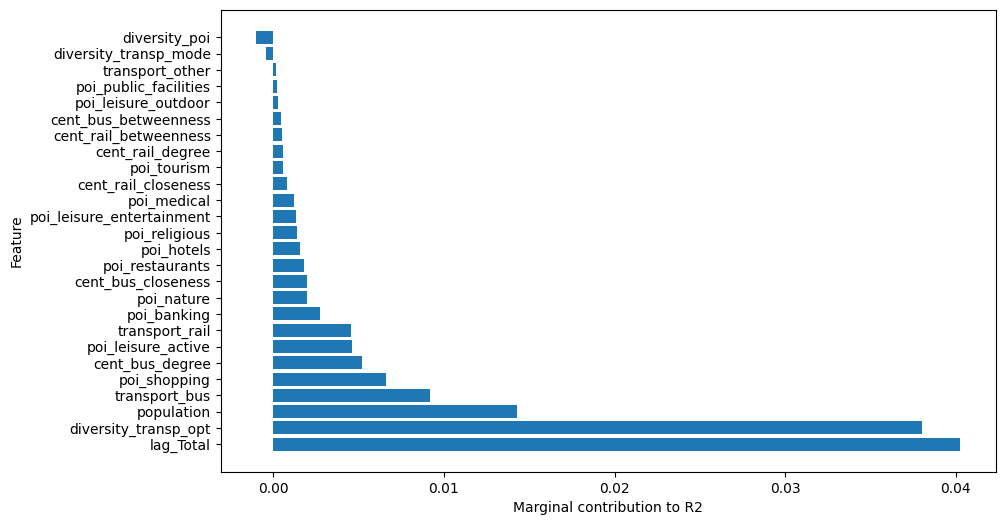

In [52]:
# plot 2 columns
plt.figure(figsize=(10,6))
plt.barh(results_perm['Feature'], results_perm['R2_diff'])
plt.xlabel('Marginal contribution to R2')
plt.ylabel('Feature')
plt.savefig('output/marginal_contribution.jpg')
plt.show()